In [135]:
import keras 
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.kernel_approximation import RBFSampler
from sklearn import pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
import random
from sklearn import random_projection

### import the MNIST dataset

In [93]:
#load the dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#reshape the images data 
print(np.shape(x_train))
x_train_reshape = x_train.reshape(60000, 784)
x_test_reshape = x_test.reshape(10000, 784)
x_train_reshape = x_train_reshape/255
x_test_reshape = x_test_reshape/255
#shape of training/test data
print("training data:", np.shape(x_train_reshape),np.shape(y_train))
print("test data:",np.shape(x_test_reshape),np.shape(y_test))

(60000, 28, 28)
training data: (60000, 784) (60000,)
test data: (10000, 784) (10000,)


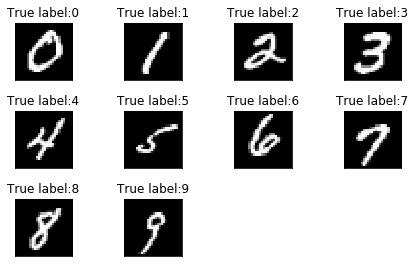

In [11]:
lst = [1,3,5,7,9,11,13,15,17,19]
fig = plt.figure()
for i in range(10):
    num = lst[i]
    plt.subplot(3, 4, i+1);
    plt.tight_layout()
    sample= x_train[num]
    sample_label=y_train[num]
    image = np.reshape(sample,(28,28),order='A')
    plt.imshow(image,cmap='gray')
    plt.title("True label:{}".format(y_train[num]))
    plt.xticks([])
    plt.yticks([])
fig

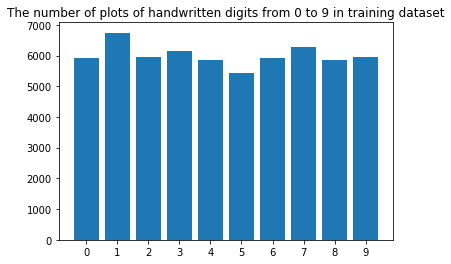

In [13]:
num_lst = [5923,6742,5958,6131,5842,5421,5918,6265,5851,5949]
bar = plt.bar(range(10),num_lst,tick_label=[i for i in range(10)])
plt.title("The number of plots of handwritten digits from 0 to 9 in training dataset")
plt.show()

### using PCA transformation on MNIST

In [58]:
%%time
#reduce dimensionality by projecting data to lower dimensional space by PCA
#ensure the variance explained by principal components >= 90%
pca_90 = PCA(n_components = 0.90)
x_train_pca_90 = pca_90.fit_transform(x_train_reshape)
print("The dimensionality is reduced to {} with 90% explained variance".format(pca_90.n_components_))

The dimensionality is reduced to 87 with 90% explained variance
CPU times: user 55.9 s, sys: 1min 15s, total: 2min 11s
Wall time: 4.75 s


In [59]:
%%time 
pca_85 = PCA(n_components = 0.85)
x_train_pca_85 = pca_85.fit_transform(x_train_reshape)
print("The dimensionality is reduced to {} with 85% explained variance".format(pca_85.n_components_))

The dimensionality is reduced to 59 with 85% explained variance
CPU times: user 56 s, sys: 1min 17s, total: 2min 12s
Wall time: 4.86 s


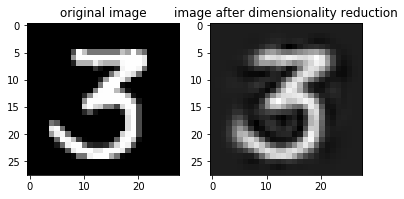

In [63]:
#transform the dimension-reduced data back to its original space.
reduced_x_train = pca_90.inverse_transform(x_train_pca)
#choose the index of an image in training dataset randomly 
num = random.randint(0,60000)
#display the randomly chosen image 
plt.subplot(1, 2, 1);
plt.imshow(x_train[num].reshape(28,28),
           cmap ='gray')
plt.title('original image')
#display the same image after dimensionality reduction 
plt.subplot(1, 2, 2);
plt.imshow(reduced_x_train[num].reshape(28,28),
           cmap ='gray')
plt.title('image after dimensionality reduction')
plt.show()

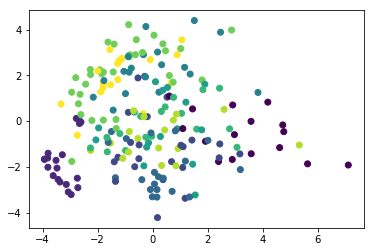

In [65]:
labels = np.unique(y_train)
#standardize data (mean = 0 and variance = 1)
x_train_pca_standardized = StandardScaler().fit_transform(x_train_pca)
#randomly selest a subset of training dataset
scatter_num = 200
random_lst = [random.randint(0,60000) for i in range(scatter_num)]
x_train_pca_chosen = np.array([x_train_pca_90[i] for i in random_lst])
y_train_chosen = [y_train[i] for i in random_lst]

plt.scatter(x_train_pca_chosen[:, 0], x_train_pca_chosen[:, 1], c=y_train_chosen)
plt.show()

In [44]:
%%time
rp_transformer = random_projection.GaussianRandomProjection(eps=0.8)
x_train_rp = rp_transformer.fit_transform(x_train_reshape)
print(np.shape(x_train_rp))

(60000, 294)
CPU times: user 13.6 s, sys: 0 ns, total: 13.6 s
Wall time: 1.27 s


In [49]:
%%time
x_test_rp = rp_transformer.transform(x_test_reshape)
random_forest = RandomForestClassifier(n_estimators=10,bootstrap=True)
random_forest.fit(x_train_rp, y_train)
rp_score = random_forest.score(x_test_rp, y_test)
print("The accuracy of random projection on test data is",rp_score)

The accuracy of random projection on test data is 0.892
CPU times: user 37.5 s, sys: 0 ns, total: 37.5 s
Wall time: 36.7 s


### logistic regression with/without PCA

In [61]:
%%time
#create logistic regression classifier using default value
logi_regr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
logi_regr.fit(x_train_reshape, y_train)
logi_score = logi_regr.score(x_test_reshape, y_test)
print(logi_score)

0.9258
CPU times: user 4min 5s, sys: 6min 43s, total: 10min 48s
Wall time: 16.9 s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [60]:
%%time
x_test_pca_90 = pca_90.transform(x_test_reshape)
logi_regr_pca_90 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
logi_regr_pca_90.fit(x_train_pca_90, y_train)
score_logi_pca_90 = logi_regr_pca_90.score(x_test_pca_90, y_test)
print("The accuracy of logistic regression after pca is:",score_logi_pca_90)

The accuracy of logistic regression after pca is: 0.9192
CPU times: user 1min 26s, sys: 3min 38s, total: 5min 4s
Wall time: 8.25 s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [66]:
%%time
x_test_pca_85 = pca_85.transform(x_test_reshape)
logi_regr_pca_85 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
logi_regr_pca_85.fit(x_train_pca_85, y_train)
score_logi_pca_85 = logi_regr_pca_85.score(x_test_pca_85, y_test)
print("The accuracy of logistic regression after pca is:",score_logi_pca_85)

The accuracy of logistic regression after pca is: 0.9165
CPU times: user 1min 21s, sys: 3min 48s, total: 5min 9s
Wall time: 8.01 s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Random Forest with/without PCA

In [67]:
%%time
random_forest = RandomForestClassifier(n_estimators=10,bootstrap=True)
random_forest.fit(x_train_reshape, y_train)
rf_score = random_forest.score(x_test_reshape, y_test)
print("The accuracy of random forest on test data is",rf_score)

The accuracy of random forest on test data is 0.9463
CPU times: user 3.88 s, sys: 122 ms, total: 4 s
Wall time: 4.15 s


In [188]:
%%time
x_test_pca_90 = pca_90.transform(x_test_reshape)
#use random forest after using pca to achieve dimensionality reduction
random_forest_pca_90 = RandomForestClassifier(n_estimators=10,bootstrap=True)
random_forest_pca_90.fit(x_train_pca_90, y_train)
rf_score_pca_90 = random_forest_pca_90.score(x_test_pca_90, y_test)
print("The accuracy of random forest after PCA 90% transformation",rf_score_pca_90)

The accuracy of random forest after PCA 90% transformation 0.9095
CPU times: user 8.66 s, sys: 3 s, total: 11.7 s
Wall time: 7.58 s


In [71]:
%%time
x_test_pca_85 = pca_85.transform(x_test_reshape)
#use random forest after using pca to achieve dimensionality reduction
random_forest_pca_85 = RandomForestClassifier(n_estimators=10,bootstrap=True)
random_forest_pca_85.fit(x_train_pca_85, y_train)
rf_score_pca_85 = random_forest_pca_85.score(x_test_pca_85, y_test)
print("The accuracy of random forest after PCA 85% transformation",rf_score_pca_85)

The accuracy of random forest after PCA 85% transformation 0.921
CPU times: user 7.29 s, sys: 3.76 s, total: 11 s
Wall time: 5.95 s


### support vector machine (SVM) with\without PCA

In [34]:
%%time
svm_classifier = svm.SVC(gamma=0.001)
svm_classifier.fit(x_train_reshape,y_train)
svm_score = svm_classifier.score(x_test_reshape, y_test)
print("The accuracy of support vector machine for original data is",svm_score)

The accuracy of support vector machine after PCA transformation 0.9417
CPU times: user 48min 56s, sys: 0 ns, total: 48min 56s
Wall time: 50min 56s


In [ ]:
%%time
svm_classifier_pca_90 = svm.SVC(gamma=0.001)
svm_classifier_pca_90.fit(x_train_pca_90,y_train)
svm_score_pca_90 = svm_classifier_pca_90.score(x_test_pca_90, y_test)
print("The accuracy of support vector machine after PCA 90% transformation",svm_score_pca_90)

In [ ]:
%%time
svm_classifier_pca_85 = svm.SVC(gamma=0.001)
svm_classifier_pca_85.fit(x_train_pca_85,y_train)
svm_score_pca_85 = svm_classifier_pca_85.score(x_test_pca_85, y_test)
print("The accuracy of support vector machine after PCA 85% transformation",svm_score_pca_85)

### linear discriminant analysis (LDA)

In [134]:
%%time
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_reshape, y_train)
lda_score = lda.score(x_test_reshape, y_test)
print("The accuracy of lda on for original data is",lda_score)

The accuracy of lda on for original data is 0.873
CPU times: user 58.9 s, sys: 1min 51s, total: 2min 50s
Wall time: 23.6 s


/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [145]:
%%time
lda_pca_90 = LinearDiscriminantAnalysis()
lda_pca_90.fit(x_train_pca_90, y_train)
lda_score_pca_90 = lda_pca_90.score(x_test_pca_90, y_test)
print("The accuracy of lda after pca 90% transformation",lda_score_pca_90)

The accuracy of lda after pca 90% transformation 0.877
CPU times: user 2.8 s, sys: 1.91 s, total: 4.71 s
Wall time: 798 ms


In [146]:
%%time
lda_pca_85 = LinearDiscriminantAnalysis()
lda_pca_85.fit(x_train_pca_85, y_train)
lda_score_pca_85 = lda_pca_85.score(x_test_pca_85, y_test)
print("The accuracy of lda after pca 85% transformation",lda_score_pca_85)

The accuracy of lda after pca 85% transformation 0.8753
CPU times: user 1.1 s, sys: 1.02 s, total: 2.12 s
Wall time: 537 ms


### quadractic discriminant analysis(QDA)

In [136]:
%%time
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train_reshape, y_train)
qda_score = qda.score(x_test_reshape, y_test)
print("The accuracy of lda on for original data is",qda_score)

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


The accuracy of lda on for original data is 0.5466
CPU times: user 3min 9s, sys: 8min 25s, total: 11min 35s
Wall time: 40.7 s


### Autoencoder

In [121]:
#reload the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)

In [108]:
encoding_dim = 32
input_dim = (np.shape(x_train)[1])
compression_factor = float(input_dim) / encoding_dim
print("Compression factor is {}%".format(compression_factor))

autoencoder = Sequential()
#create encoded representation of the input
autoencoder.add(Dense(encoding_dim, input_shape=(input_dim,),activation='relu'))
#create reconstruction of the input
autoencoder.add(Dense(input_dim, activation='sigmoid'))
autoencoder.summary()

Compression factor is 24.5%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_14 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [109]:
input_img = Input(shape=(input_dim,))
#extract the encoder layer from autoencoder model
encoder_layer = autoencoder.layers[0]
encoder_model = Model(input_img, encoder_layer(input_img))
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [110]:
#train the autoencoder to reconstruct MNIST digits
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
13568/60000 [=====>........................] - ETA: 0s - loss: 0.4421

/usr/local/src/incubator-mxnet/python/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.00390625). Is this intended?
  force_init=force_init)


60000/60000 [==============================] - 1s 12us/step - loss: 0.2746 - val_loss: 0.1894
Epoch 2/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1705 - val_loss: 0.1522
Epoch 3/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1428 - val_loss: 0.1328
Epoch 4/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1279 - val_loss: 0.1213
Epoch 5/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.1185 - val_loss: 0.1136
Epoch 6/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1119 - val_loss: 0.1080
Epoch 7/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1070 - val_loss: 0.1038
Epoch 8/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1033 - val_loss: 0.1005
Epoch 9/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1003 - val_loss: 0.0978
Epoch 10/50
60000/60000 [==============================] - 1s 12us

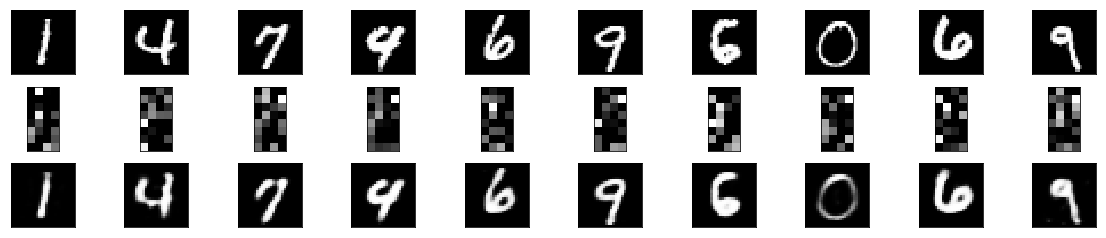

In [111]:
n = 10
np.random.seed()
random_test_images = np.random.randint(x_test.shape[0], size=n)

encoded_test_imgs = encoder_model.predict(x_test)
decoded_test_imgs = autoencoder.predict(x_test)
decoded_train_imgs = autoencoder.predict(x_train)

plt.figure(figsize=(20, 4))

for i, index in enumerate(random_test_images):
    # visualize original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # visualize encoded state
    ax = plt.subplot(3, n, n + i + 1)
    plt.imshow(encoded_test_imgs[index].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # visualize images after reconstruction
    ax = plt.subplot(3, n, 2*n + i + 1)
    plt.imshow(decoded_test_imgs[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [105]:
print(np.shape(decoded_test_imgs[index]))

(784,)


### random forest with autoencoder

In [60]:
%%time
#use random forest after autoencoder to achieve dimensionality reduction
random_forest_AE = RandomForestClassifier(n_estimators=10,bootstrap=True)
random_forest_AE.fit(decoded_train_imgs, y_train)
score_RF_AE = random_forest_AE.score(decoded_test_imgs, y_test)
print("The accuracy of random forest after autoencoder is:",score_RF_AE)

The accuracy of random forest after autoencoder is: 0.9509
CPU times: user 21.7 s, sys: 57.6 ms, total: 21.8 s
Wall time: 21.8 s


### logistic regression with autoencoder

In [120]:
print(np.shape(decoded_train_imgs))
print(np.shape(decoded_test_imgs))
print(np.shape(y_train))
print(np.shape(y_test))

(60000, 784)
(10000, 784)
(10000,)
(10000,)


### logistic regression with autoencoder

In [122]:
%%time 
logi_regr_AE = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
logi_regr_AE.fit(decoded_train_imgs, y_train)
score_logi_AE = logi_regr_AE.score(decoded_test_imgs, y_test)
print("The accuracy of logistic regression after autoencoder is:",score_logi_AE)

The accuracy of logistic regression after autoencoder is: 0.9169
CPU times: user 4min, sys: 4min 13s, total: 8min 14s
Wall time: 13 s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### SVM with autoencoder

In [125]:
%%time
svm_classifier_AE = svm.SVC(gamma=0.001)
svm_classifier_AE.fit(decoded_train_imgs, y_train)
svm_score_AE = svm_classifier_AE.score(decoded_test_imgs, y_test)
print("The accuracy of support vector machine after autoencoder is",svm_score_AE)

The accuracy of support vector machine after autoencoder is 0.9262
CPU times: user 25min 54s, sys: 77.3 ms, total: 25min 54s
Wall time: 25min 53s


In [147]:
%%time
lda_AE = LinearDiscriminantAnalysis()
lda_AE.fit(decoded_train_imgs, y_train)
lda_score_AE = lda_AE.score(decoded_test_imgs, y_test)
print("The accuracy of lda after autoencoder is",lda_score_AE)

The accuracy of lda after autoencoder is 0.8736
CPU times: user 57.3 s, sys: 1min 4s, total: 2min 2s
Wall time: 8.6 s


### plot of the classification accuracy

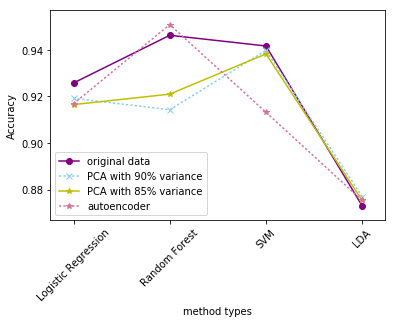

In [189]:
import matplotlib.pyplot as plt
names = ['Logistic Regression', 'Random Forest', 'SVM', 'LDA']
x = range(len(names))
original_data_acc = [0.9258, 0.9463, 0.9417,0.873]
PCA_90_acc = [0.9192, 0.9143, 0.9398,0.877]
PCA_85_acc = [0.9165, 0.921, 0.9383, 0.8753]
autoencoder = [0.9169,0.9509,0.9132, 0.8753]

plt.plot(x, original_data_acc,color='purple',linestyle='-',marker='o',label='original data')
plt.plot(x,PCA_90_acc,color='skyblue',linestyle=':',marker='x',label='PCA with 90% variance')
plt.plot(x,PCA_85_acc,'y*-',label='PCA with 85% variance')
plt.plot(x,autoencoder,color='palevioletred',linestyle=':',marker='*',label='autoencoder')

plt.xticks(x, names, rotation=45)
plt.margins(0.08)
plt.subplots_adjust(bottom=0.15)
plt.xlabel('method types')
plt.ylabel('Accuracy')
#plt.title('The plot of classification accuracies of other machine learning methods')
plt.legend()
plt.show()